In [1]:
import os
import requests
import jwt
import time
import sqlite3
import json
import concurrent.futures
import queue
import threading

def save_to_file(data, file_path):
    with open(file_path, 'w') as file:
        # file.write(data)
        json.dump(data, file)

def load_from_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def generate_jwt_token(client_id, client_secret):
    # Replace with the appropriate token endpoint URL for your OAuth server
    token_endpoint = "https://web.arbeitsagentur.de/weiterbildungssuche/suche"

    now = int(time.time())
    payload = {
        "iss": client_id,
        "sub": client_id,
        "aud": token_endpoint,
        "iat": now,
        "exp": now + 3600,  # Token expires in 1 hour
    }

    # Sign the payload with your client secret to generate the JWT
    jwt_token = jwt.encode(payload, client_secret, algorithm='HS256')

    return jwt_token

def get_access_token(client_id, client_secret):
    # Generate the JWT token
    jwt_token = generate_jwt_token(client_id, client_secret)

    # Request the access token using the JWT token
    token_endpoint = "https://rest.arbeitsagentur.de/oauth/gettoken_cc"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
    }
    data = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }

    response = requests.post(token_endpoint, headers=headers, data=data)

    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        raise Exception(f"Failed to get access token. Status code: {response.status_code}")

def get_api_data(api_url, access_token, params=None):
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/x-www-form-urlencoded"
    }
    response = requests.get(api_url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()



def create_table(db_connection):
    cursor = db_connection.cursor()
    # Create a table if it doesn't exist
    cursor.execute('''CREATE TABLE IF NOT EXISTS weiterbildung_data
                            (
                                unterrichtsform_id INT,
                                unterrichtsform_bezeichnung TEXT,
                                unterrichtszeit_id INT,
                                unterrichtszeit_bezeichnung TEXT,
                                dauer_id INT,
                                dauer_bezeichnung TEXT,
                                angebot_id INT,
                                angebot_titel TEXT NULL,
                                angebot_bildungsanbieter_id INT NULL,
                                angebot_bildungsanbieter_name TEXT NULL,
                                bildungsanbieter_adresse_id INT NULL,
                                bildungsanbieter_adresse_bezeichnung TEXT NULL,
                                bildungsanbieter_adresse_strasse TEXT NULL,
                                bildungsanbieter_adresse_hinweise TEXT NULL,
                                bildungsanbieter_ortStrasse_id INT NULL,
                                bildungsanbieter_ortStrasse_plz TEXT NULL,
                                bildungsanbieter_ortStrasse_name TEXT NULL,
                                bildungsanbieter_ortStrasse_land_id INT NULL,
                                bildungsanbieter_ortStrasse_land_name TEXT NULL,
                                bildungsanbieter_ortStrasse_land_laenderCode TEXT NULL,
                                bildungsanbieter_ortStrasse_land_bundeslandCode TEXT NULL,
                                bildungsanbieter_ortStrasse_land_code TEXT NULL,
                                bildungsanbieter_koordinaten_lat REAL NULL,
                                bildungsanbieter_koordinaten_lon REAL NULL,
                                adresse_id INT NULL,
                                adresse_bezeichnung TEXT NULL,
                                adresse_strasse TEXT NULL,
                                adresse_hinweise TEXT NULL,
                                ortStrasse_id INT NULL,
                                ortStrasse_plz TEXT NULL,
                                ortStrasse_name TEXT NULL,
                                ortStrasse_land_id INT NULL,
                                ortStrasse_land_name TEXT NULL,
                                ortStrasse_land_laenderCode TEXT NULL,
                                ortStrasse_land_bundeslandCode TEXT NULL,
                                ortStrasse_land_code TEXT NULL,
                                koordinaten_lat REAL NULL,
                                koordinaten_lon REAL NULL,
                                bildungsart_id INT NULL,
                                bildungsart_bezeichnung TEXT NULL,
                                beginn TIMESTAMP,
                                ende TIMESTAMP,
                                kostenWert TEXT NULL,
                                kostenWaehrung TEXT NULL ,
                                kostenBemerkung TEXT NULL,
                                teilnehmerMax INT NULL,
                                teilnehmerMin INT NULL,
                                individuellerEinstieg BOOLEAN NULL,
                                inhouseFirmenseminar BOOLEAN NULL,
                                praxisanteile BOOLEAN NULL,
                                foerderung BOOLEAN NULL
                                )
                ''')
    db_connection.commit()

In [2]:

def insert_data_into_db(data, db_connection):
    cursor = db_connection.cursor()
    for entry in data:
        unterrichtsform = entry["unterrichtsform"]
        unterrichtszeit = entry["unterrichtszeit"]
        dauer = entry["dauer"]
        angebot = entry["angebot"]
        adresse = entry["adresse"]
        
        if(adresse != None):
            bildungsanbieter_address = angebot["bildungsanbieter"]["adresse"]
            cursor.execute('''INSERT INTO weiterbildung_data (
                    unterrichtsform_id, unterrichtsform_bezeichnung, unterrichtszeit_id, unterrichtszeit_bezeichnung, 
                    dauer_id, dauer_bezeichnung,
                    angebot_id, angebot_titel, angebot_bildungsanbieter_id,
                    angebot_bildungsanbieter_name, bildungsanbieter_adresse_id, bildungsanbieter_adresse_bezeichnung,
                    bildungsanbieter_adresse_strasse, bildungsanbieter_adresse_hinweise, bildungsanbieter_ortStrasse_id,
                    bildungsanbieter_ortStrasse_plz, bildungsanbieter_ortStrasse_name,
                    bildungsanbieter_ortStrasse_land_id, bildungsanbieter_ortStrasse_land_name,
                    bildungsanbieter_ortStrasse_land_laenderCode, bildungsanbieter_ortStrasse_land_bundeslandCode,
                    bildungsanbieter_ortStrasse_land_code, bildungsanbieter_koordinaten_lat,
                    bildungsanbieter_koordinaten_lon,adresse_id,adresse_bezeichnung, 
                    adresse_strasse, adresse_hinweise, ortStrasse_id, ortStrasse_plz,
                    ortStrasse_name, ortStrasse_land_id, ortStrasse_land_name, ortStrasse_land_laenderCode,
                    ortStrasse_land_bundeslandCode, ortStrasse_land_code, koordinaten_lat,
                    koordinaten_lon, bildungsart_id,
                    bildungsart_bezeichnung, beginn, ende, kostenWert, kostenWaehrung, kostenBemerkung,
                    teilnehmerMax, teilnehmerMin, individuellerEinstieg, inhouseFirmenseminar, praxisanteile,foerderung 
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
                ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                unterrichtsform["id"], unterrichtsform["bezeichnung"], unterrichtszeit["id"], unterrichtszeit["bezeichnung"],
                dauer["id"], dauer["bezeichnung"],
                angebot["id"], angebot["titel"], 
                angebot["bildungsanbieter"]["id"], angebot["bildungsanbieter"]["name"], 
                bildungsanbieter_address["id"], bildungsanbieter_address["bezeichnung"],bildungsanbieter_address["strasse"],
                bildungsanbieter_address["hinweise"], bildungsanbieter_address["ortStrasse"]["id"],
                bildungsanbieter_address["ortStrasse"]["plz"], bildungsanbieter_address["ortStrasse"]["name"],
                bildungsanbieter_address["ortStrasse"]["land"]["id"], bildungsanbieter_address["ortStrasse"]["land"]["name"], 
                bildungsanbieter_address["ortStrasse"]["land"]["laenderCode"],bildungsanbieter_address["ortStrasse"]["land"]["bundeslandCode"],
                bildungsanbieter_address["ortStrasse"]["land"]["code"], bildungsanbieter_address["koordinaten"]["lat"],
                bildungsanbieter_address["koordinaten"]["lon"],adresse["id"],adresse["bezeichnung"],adresse["strasse"],
                adresse["hinweise"],adresse["ortStrasse"]["id"],adresse["ortStrasse"]["plz"],
                adresse["ortStrasse"]["name"],adresse["ortStrasse"]["land"]["id"],adresse["ortStrasse"]["land"]["name"], adresse["ortStrasse"]["land"]["laenderCode"],
                adresse["ortStrasse"]["land"]["bundeslandCode"],adresse["ortStrasse"]["land"]["code"], adresse["koordinaten"]["lat"],
                adresse["koordinaten"]["lon"],angebot["bildungsart"]["id"], angebot["bildungsart"]["bezeichnung"], entry["beginn"], entry["ende"],
                entry["kostenWert"],entry["kostenWaehrung"],entry["kostenBemerkung"],
                entry["teilnehmerMax"],entry["teilnehmerMin"],entry["individuellerEinstieg"],entry["inhouseFirmenseminar"],entry["praxisanteile"],entry["foerderung"]
            ))
    db_connection.commit()
    print("insert data")

In [4]:
import parameters
# load data with all filters
param = parameters.init()
print(parameters.regions)

['BAW', 'BAY', 'BER', 'BRA', 'BRE', 'HAM', 'HES', 'MBV', 'NDSNRW', 'RPF', 'SAA', 'SAC', 'SAN', 'SLH', 'TH%C3%9C', 'iGB', 'iP', 'iCH', 'iA', 'iE']


In [4]:
# Pagination: Fetch all data from the API using multiple requests
def pagination(api_url, access_token, db_connection, params, data_queue, page):
    params = params.copy()
    params["page"] = page
    api_data = get_api_data(api_url, access_token, params)
    if api_data["page"]["totalPages"] != 0:
        data_queue.put(api_data["_embedded"]["termine"])
        # insert_data_into_db(api_data["_embedded"]["termine"], db_connection)
        if page < api_data["page"]["totalPages"] - 1:
            pagination(api_url, access_token, db_connection, params, data_queue, page + 1)
    
    
def writer_thread(db_connection, data_queue):
    while True:
        data = data_queue.get()
        if data is None:
            # Signal to exit
            break
        print("insertion",len(data))
        insert_data_into_db(data)
        data_queue.task_done()

def fetch_data(db_connection, data_queue, params=None):
    api_url = "https://rest.arbeitsagentur.de/infosysbub/wbsuche/pc/v1/bildungsangebot"  # Replace with the API endpoint URL
    data_file = "data_json.txt"
    client_id = "38053956-6618-4953-b670-b4ae7a2360b1"  # Replace with your OAuth client ID
    client_secret = "c385073c-3b97-42a9-b916-08fd8a5d1795"  # Replace with your OAuth client secret

    # Get the access token using client credentials flow with JWTs
    access_token = get_access_token(client_id, client_secret)
    regions = parameters.regions
    dauer = parameters.dauer
    beginntermin = parameters.beginntermin
    unterrichtsform = parameters.unterrichtsform
    
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=55) as executor:  # Adjust max_workers as needed
        futures = []
        for region_item in regions:
            print(region_item)
            for dauer_item in dauer:
                for begintermin in beginntermin:
                    for urf in unterrichtsform:
                        for uz in parameters.unterrichtszeit:
                            for sys in parameters.systematik:
                                params = {
                                    "re": region_item,
                                    "uk": "Bundesweit",
                                    "uf": urf,
                                    "bt": begintermin,
                                    "dauer": dauer_item,
                                    "uz": uz,
                                    "sys": sys,
                                    "size": 20  # Limit per page as per API's limitation
                                }
                                futures.append(executor.submit(pagination, api_url, access_token, db_connection, params, data_queue, 0))

        # Wait for all tasks to complete
        concurrent.futures.wait(futures)

In [5]:
def main():
    # Open a connection
    db_connection = sqlite3.connect('weiterbildung_analysis.db')
    create_table(db_connection)
    
    data_queue = queue.Queue()

    fetch_data(db_connection, data_queue)
    
    # Process the fetched data from the queue and insert into the database
    while not data_queue.empty():
        data = data_queue.get()
        print(len(data))
        insert_data_into_db(data,db_connection)
        data_queue.task_done()
        
    # Close the database connection
    db_connection.close()


if __name__ == "__main__":
    main()

BER
1
insert data
20
insert data
20
insert data
20
insert data
20
insert data
4
insert data
17
insert data
2
insert data
4
insert data
2
insert data
17
insert data
2
insert data
2
insert data
1
insert data
1
insert data
20
insert data
20
insert data
20
insert data
20
insert data
20
insert data
19
insert data
9
insert data
1
insert data
20
insert data
20
insert data
20
insert data
20
insert data
20
insert data
1
insert data
2
insert data
19
insert data
9
insert data
2
insert data
1
insert data
20
insert data
20
insert data
2
insert data
20
insert data
20
insert data
20
insert data
1
insert data
20
insert data
20
insert data
20
insert data
2
insert data
6
insert data
20
insert data
20
insert data
20
insert data
20
insert data
20
insert data
20
insert data
4
insert data
20
insert data
20
insert data
20
insert data
20
insert data
1
insert data
6
insert data
1
insert data
13
insert data
20
insert data
20
insert data
5
insert data
13
insert data
11
insert data
11
insert data
6
insert data
5


Connection to Sqlite to retrieve the dataframe

In [ ]:
import pandas as pd
import sqlite3
import plotly.express as px

# Connect to the SQLite database
conn = sqlite3.connect('weiterbildung_analysis.db')
cursor = conn.cursor()

query = """
    SELECT *
    FROM weiterbildung_data
"""

# Execute the SQL query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)

# drop the null values
df = df.drop_duplicates()

# Display the first few rows of the DataFrame
print(len(df))


157865


Weiterbildung Count by Region

<Figure size 2000x600 with 0 Axes>

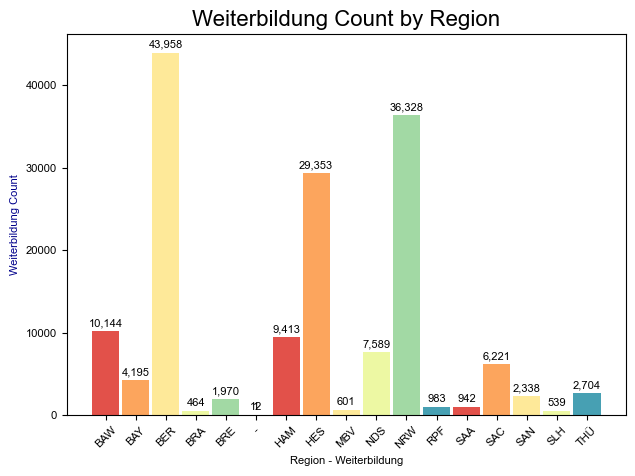

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

# group by region 
region_grouped_data = df.groupby([
    'bildungsanbieter_ortStrasse_land_name',
    'bildungsanbieter_ortStrasse_land_bundeslandCode'
    ])['angebot_titel'].count().reset_index(name='Weiterbildung_Count')
region_grouped_data.rename(columns={'bildungsanbieter_ortStrasse_land_name': 'Region', 'bildungsanbieter_ortStrasse_land_bundeslandCode': 'Region Code'}, inplace=True)

region_grouped_data= region_grouped_data.drop([5])

plt.figure(figsize=(20, 6))

# Create a bar plot
fig, ax1 = plt.subplots()

# Plot the count of weiterbildung
bars = ax1.bar(region_grouped_data['Region Code'], region_grouped_data['Weiterbildung_Count'], color=sns.color_palette("Spectral"), label=region_grouped_data['Region Code'],width=0.9, align="center")

ax1.bar_label(bars,fmt='{:,.0f}',padding= 2)
ax1.set_xlabel('Region - Weiterbildung')
ax1.set_ylabel('Weiterbildung Count', color='darkblue')

plt.title('Weiterbildung Count by Region', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from keplergl import KeplerGl

df2 = df[['bildungsanbieter_ortStrasse_land_name', 'angebot_titel', 'unterrichtsform_bezeichnung', 'unterrichtszeit_bezeichnung', 'koordinaten_lat', 'koordinaten_lon']]

# Read a GeoDataFrame
world_gdf = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

# Create Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(df2['koordinaten_lon'], df2['koordinaten_lat'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df2, geometry=geometry, crs='EPSG:4326')

# Filter data for Germany
germany_boundary = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany_boundary = germany_boundary[germany_boundary['name'] == 'Germany']
gdf = gdf[gdf.within(germany_boundary.unary_union)]

custom_config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [],
      "interactionConfig": {}
    },
    "mapState": {
      "latitude": 51.1657,
      "longitude": 10.4515,
      "zoom": 5,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "muted_night",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": True,
        "building": True,
        "water": True,
        "land": True
      }
    }
  }
}

# Create a Kepler.gl instance
map_1 = KeplerGl(height=800, config=custom_config)

# Add data to Kepler.gl instance
map_1.add_data(data=gdf, name='Weiterbildung Details')

# Display the Kepler.gl map
map_1
map_1.save_to_html()

# plt.scatter(df['koordinaten_lon'], df['koordinaten_lat'], color='b', marker='o')



/var/folders/lg/61gk99gx34v6h0kb8x3qvcdw0000gp/T/ipykernel_52188/2531889957.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path('naturalearth_lowres')
/var/folders/lg/61gk99gx34v6h0kb8x3qvcdw0000gp/T/ipykernel_52188/2531889957.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  germany_boundary = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to keplergl_map.html!


Top regions Weiterbildung count according to Unterrichtszeit

/var/folders/lg/61gk99gx34v6h0kb8x3qvcdw0000gp/T/ipykernel_52188/3240993132.py:28: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




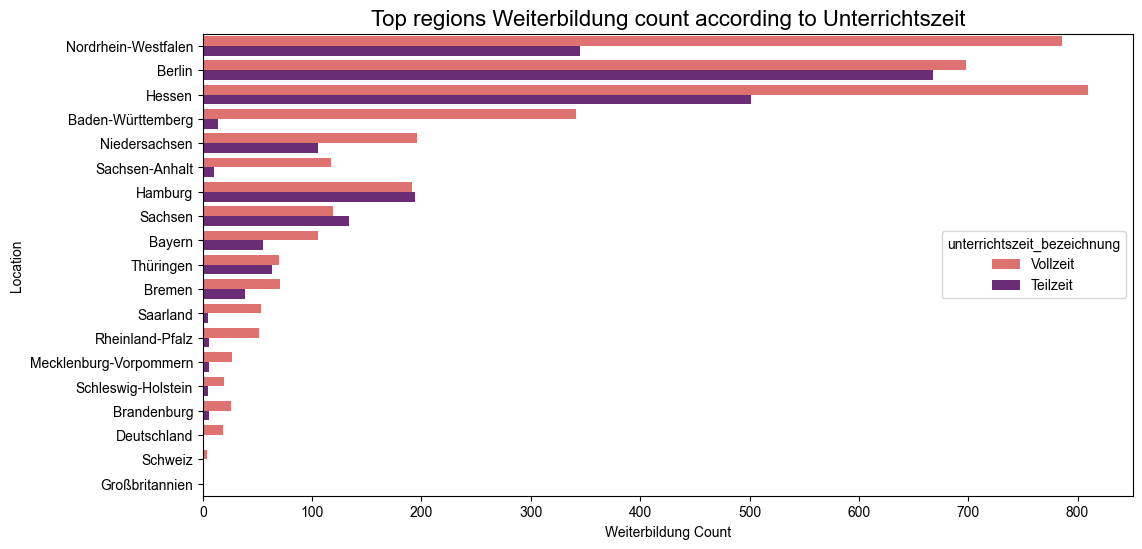

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

df3 = df.groupby([
    'unterrichtsform_bezeichnung',
    'unterrichtszeit_bezeichnung',
    'dauer_id',
    'bildungsanbieter_ortStrasse_land_name',
    ])['angebot_titel'].count().reset_index(name='Weiterbildung_Count')
cols = [
    'unterrichtsform_bezeichnung', 
    'unterrichtszeit_bezeichnung', 
    'dauer_bezeichnung', 
    'bildungsanbieter_ortStrasse_land_name', 
    ]
df3 = df3.sort_values(by='Weiterbildung_Count', ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df3, x='Weiterbildung_Count', y='bildungsanbieter_ortStrasse_land_name', hue="unterrichtszeit_bezeichnung",ci= None, palette=sns.color_palette("magma_r",2))
plt.xlabel('Weiterbildung Count')
plt.ylabel('Location')
plt.title('Top regions Weiterbildung count according to Unterrichtszeit', fontsize = 16)
plt.show()


Distribution of Dauer of the Weiterbildung

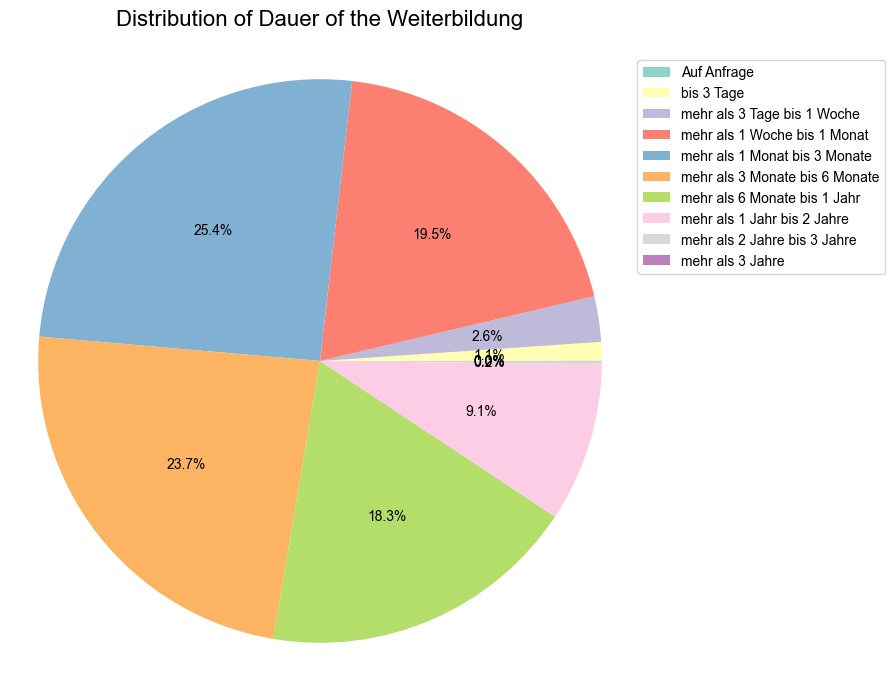

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dauer_id = np.array([0,1,2,3,4,5,6,7,8,9])
# 0=Auf Anfrage
# 1=bis 3 Tage 
# 2=mehr als 3 Tage bis 1 Woche
# 3=mehr als 1 Woche bis 1 Monat 
# 4=mehr als 1 Monat bis 3 Monate
# 5=mehr als 3 Monate bis 6 Monate 
# 6=mehr als 6 Monate bis 1 Jahr  
# 7=mehr als 1 Jahr bis 2 Jahre 
# 8=mehr als 2 Jahre bis 3 Jahre 
# 9=mehr als 3 Jahre

dauer_labels = ["Auf Anfrage","bis 3 Tage", "mehr als 3 Tage bis 1 Woche", "mehr als 1 Woche bis 1 Monat", 
                "mehr als 1 Monat bis 3 Monate", "mehr als 3 Monate bis 6 Monate", 
                "mehr als 6 Monate bis 1 Jahr", "mehr als 1 Jahr bis 2 Jahre", "mehr als 2 Jahre bis 3 Jahre", "mehr als 3 Jahre"]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0.1, 0.1) 
df4 = df3.groupby(['dauer_id']).sum()
plt.figure(figsize=(8,8))

patches, texts, _ = plt.pie(df4["Weiterbildung_Count"], labels = None, autopct='%1.1f%%',
    colors=sns.color_palette('Set3',10), textprops={'fontsize': 10}, labeldistance=1.1)

plt.legend(patches, dauer_labels, loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

plt.title(label='Distribution of Dauer of the Weiterbildung',fontdict={"fontsize":16},
    pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Kosten (Cost) based on unterrichtsform and unterrichtszeit

float32


/var/folders/lg/61gk99gx34v6h0kb8x3qvcdw0000gp/T/ipykernel_52188/3504110740.py:13: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




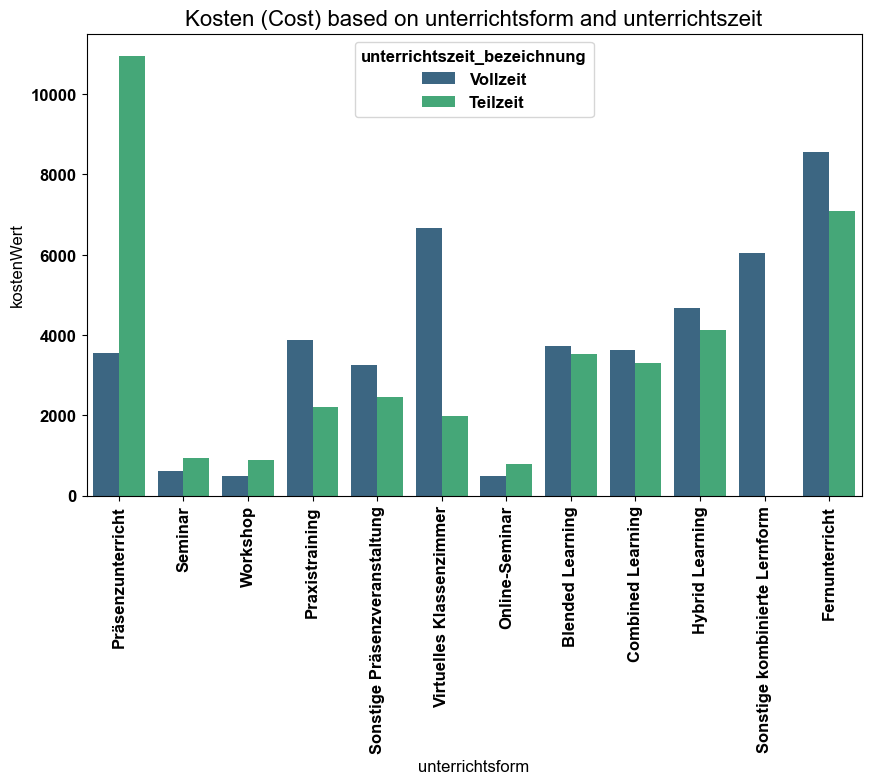

In [ ]:
plt.figure(figsize=(10, 6))

df5 = df.groupby([
    'unterrichtsform_id',
    'unterrichtsform_bezeichnung',
    'unterrichtszeit_id',
    'unterrichtszeit_bezeichnung',
    'kostenWert',
    'dauer_id'
    ])['angebot_titel'].count().reset_index(name='count')
df["kostenWert"] = pd.to_numeric(df["kostenWert"], downcast="float")
print((df['kostenWert'].dtypes))
sns.barplot(data=df5, x='unterrichtsform_bezeichnung', y='kostenWert', hue='unterrichtszeit_bezeichnung', palette='viridis', ci=None)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Customize the chart
plt.title('Kosten (Cost) based on unterrichtsform and unterrichtszeit', fontsize = 16)
plt.xlabel('unterrichtsform')
plt.ylabel('kostenWert')

plt.show()

Bildungsart Count by Region

/var/folders/lg/61gk99gx34v6h0kb8x3qvcdw0000gp/T/ipykernel_52188/1818912387.py:23: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




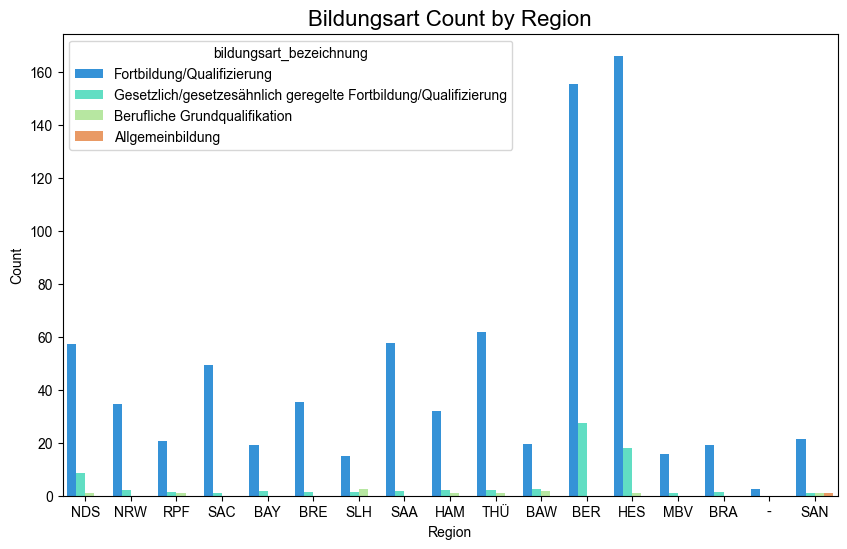

In [ ]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

df6 = df.groupby([
    'unterrichtsform_id',
    'unterrichtsform_bezeichnung',
    'unterrichtszeit_id',
    'unterrichtszeit_bezeichnung',
    'kostenWert',
    'dauer_id',
    'bildungsart_id',
    'bildungsart_bezeichnung',
    'bildungsanbieter_ortStrasse_land_bundeslandCode'
    ])['angebot_titel'].count().reset_index(name='count')

# Group the data by Bildungsart and calculate the sum Kosten
grouped_df = df6.groupby('bildungsart_bezeichnung')['count'].sum()
# Create a line graph
# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df6, x='bildungsanbieter_ortStrasse_land_bundeslandCode', y='count', hue='bildungsart_bezeichnung', palette='rainbow', ci= None)

# Customize the chart
plt.title('Bildungsart Count by Region', fontsize = 16)
plt.xlabel('Region')
plt.ylabel('Count')

plt.show()

Top 5 Providers for Weiterbildung

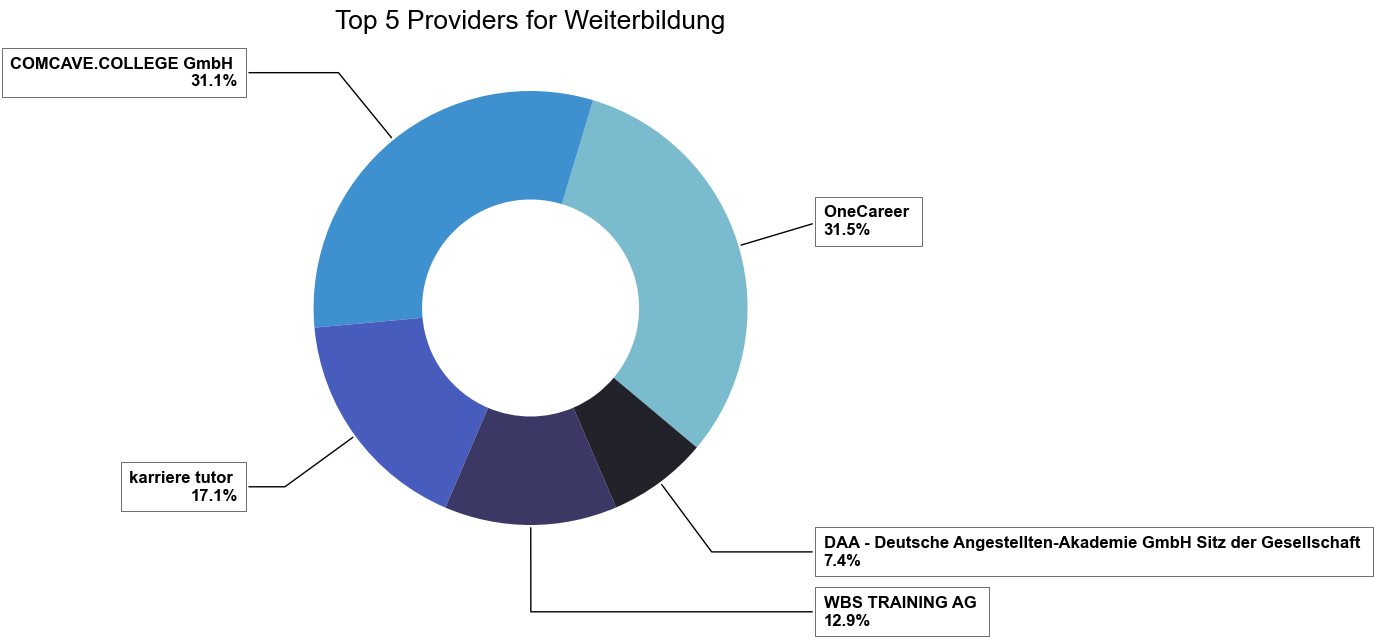

In [ ]:
from matplotlib.table import Table

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
df7 = df.groupby([
    'angebot_bildungsanbieter_name',
    'bildungsanbieter_ortStrasse_land_name'
    ])['bildungsanbieter_ortStrasse_land_name'].count().reset_index(name='count').sort_values(by="count",ascending=False)
df7 = df7.head(5)
array = df7['angebot_bildungsanbieter_name'].to_numpy()

fig, ax = plt.subplots(figsize=(7, 15), subplot_kw=dict(aspect="equal"))

# Calculate percentages
total = df7['count'].sum()
percentages = [f"{val / total * 100:.1f}%" for val in  df7['count']]

wedges, texts = ax.pie(df7["count"], wedgeprops=dict(width=0.5), startangle=-40, colors=sns.color_palette('icefire',10))
bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.4)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{array[i]} \n{percentages[i]}", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    
ax.set_title("Top 5 Providers for Weiterbildung", fontsize=19)

plt.show()